In [1]:
import pandas as pd
import numpy as np
from collections import Counter
import matplotlib.pyplot as plt
import re
import nltk
from autocorrect import Speller
from nltk.corpus import stopwords

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeClassifier

## Import the Data

In [2]:
df = pd.read_csv('Scrapper/final.csv', header=None)
# df.rename(columns={0: 'comment', 1: 'category'}, inplace=True)

## Exploring the Data

In [3]:
# Printing unique category
df[1].unique()

array(['positive', 'imperative', 'interrogative', 'other', 'correction',
       'negative'], dtype=object)

In [4]:
# removing duplicate rows
# df = df.drop_duplicates()
df.duplicated().any()

True

In [5]:
# Checking null values
df.isnull().sum()

0    0
1    0
dtype: int64

In [6]:
# Checking the shape of the data
df.shape

(1716, 2)

## Preprocessing

In [7]:
# Preprocessing

# lowercasing
df[0] = df[0].str.lower()

# removing urls
df[0] = df[0].str.replace('http\S+|www.\S+', '', case=False)

# removing new lines "\n"
df[0] = df[0].str.replace('\n',' ', regex=True)

# removing all the punctuations
df[0] = df[0].str.replace('[^\w\s]',' ')

# removing integers
df[0] = df[0].str.replace('\d','', regex=True)

# removing emojis
df[0] = df[0].str.replace('[^\w\s#@/:%.,_-]', ' ', flags=re.UNICODE)
df

,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1711,thanks very much for taking the time to put up...,positive
1712,i have installed java but why jre folder not s...,imperative
1713,i dont see the jre file below the jdk did i do...,interrogative
1714,turn up your microphone,imperative


In [8]:
# df.rename(columns={'comment':0, 'category':1}, inplace=True)
# df

In [9]:
# # correcting the typos

# spell = Speller(lang='en')

# def typo_corrector(text):
#     return spell(text)

# df[0] = df[0].apply(typo_corrector)
# df[0]

In [10]:
lemmatizer = nltk.stem.WordNetLemmatizer()
def lemmatize_text(text):
    return lemmatizer.lemmatize(text)

df[0] = df[0].apply(lemmatize_text)
df

# # # stemming
# stemmer = nltk.stem.SnowballStemmer('english')
# def stem_text(text):
#     return stemmer.stem(text)

# df[0] = df[0].apply(stem_text)
# df

# lemmatizing

# nltk.download('wordnet')



,0,1
0,love you sir,positive
1,please make videos on midpoint circle drawing...,imperative
2,i bought both of your courses on udemy you ar...,interrogative
3,thank you very much u really got me in the fi...,positive
4,i hope u are ok with everything going on again...,other
...,...,...
1711,thanks very much for taking the time to put up...,positive
1712,i have installed java but why jre folder not s...,imperative
1713,i dont see the jre file below the jdk did i do...,interrogative
1714,turn up your microphone,imperative


In [11]:
# Removing stopwords
# nltk.download('stopwords')

stop = stopwords.words('english')

# These are the words that should not be removed from their category
negative_words = ['no','not']
interrogative_words = ['how','what','which','who','whom','why','do','does','is','are','was','were','will','am',
                      'are','could','would','should','can','did','does','do','had','have']
imperative_words = ['could','would','should','can']

for_negative_category = stop.copy()
for word in negative_words:
    if word in for_negative_category:
        for_negative_category.remove(word)
    
for_interrogative_category = stop.copy()
for word in interrogative_words:
    if word in for_interrogative_category:
        for_interrogative_category.remove(word)
    
for_imperative_category = stop.copy()
for word in imperative_words:
    if word in for_imperative_category:
        for_imperative_category.remove(word)

# For negative category
for i in range(len(df)):
    if df[1][i] == "negative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_negative_category])

# For interrogative category
for i in range(len(df)):
    if df[1][i] == "interrogative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_interrogative_category])
        
# For interrogative category
for i in range(len(df)):
    if df[1][i] == "imperative":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in for_imperative_category])
        
# For all other category
for i in range(len(df)):
    if df[1][i] == "positive" or df[1][i] == "correction" or df[1][i] == "other":
        df[0][i] = ' '.join([word for word in df[0][i].split() if word not in stop])

# df[0] = df[0].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))
# df

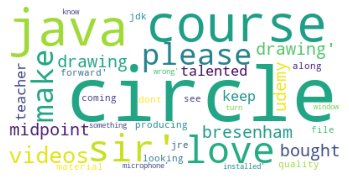

In [65]:
from wordcloud import WordCloud
text = df[0].values 

wordcloud = WordCloud(background_color='white',collocations=False).generate(str(text))

plt.imshow(wordcloud)
plt.axis("off")
plt.show()

## Feature Extaction

In [12]:
import math 

N_occurance = 5

words = [df[0][i].split() for i in range(len(df))]
bag_of_words = sorted(list({word for list_ in words for word in list_}))
word_count = {word:0 for word in bag_of_words}
for word in bag_of_words:
    for list_ in words:
        if word in list_:
            word_count[word]+=1
filtered_words = [k for k,v in word_count.items() if v>N_occurance]
evaluation = np.zeros((len(df),len(filtered_words)))
for i in range(len(words)):
    counter = Counter(words[i])
    for k, v in counter.items():
        if k not in filtered_words:
            continue
        count = [1 for list_ in words if k in list_]
        evaluation[i][filtered_words.index(k)] = sum(count)/len(words)

# print(filtered_words)
evaluation.shape

(1716, 449)

In [13]:
# features = evaluation
# features

In [14]:
from sklearn import preprocessing
# features = preprocessing.normalize(evaluation, norm='l2')
# features

# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# features = scaler.fit_transform(evaluation)

min_max_scaler = preprocessing.MinMaxScaler()
features = min_max_scaler.fit_transform(evaluation)

# scaler = preprocessing.RobustScaler()
# features = scaler.fit_transform(evaluation)

## Applying models and calculating the scores

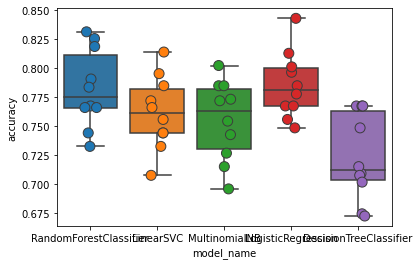

In [15]:
# Applying models

labels = df[1]
models = [
    RandomForestClassifier(n_estimators=200, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
    DecisionTreeClassifier(),
]

cv_df = pd.DataFrame()
entries = []

for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, features, labels, scoring='accuracy', cv=10)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))

cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

import seaborn as sns
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, size=10, jitter=True, linewidth=1)
plt.show()

In [16]:
# Printing the accuracies
cv_df.groupby('model_name').accuracy.mean()

model_name
DecisionTreeClassifier    0.723157
LinearSVC                 0.761652
LogisticRegression        0.785547
MultinomialNB             0.755212
RandomForestClassifier    0.782636
Name: accuracy, dtype: float64

## Appyling other models

In [17]:
X = features
y = df.iloc[:, 1].values

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
# Multinomial NB
from sklearn.naive_bayes import MultinomialNB

classifier = MultinomialNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7877906976744186


In [20]:
# Linear SVC
from sklearn.svm import SVC

classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7906976744186046


In [21]:
# Logistic Regression
from sklearn.linear_model import LogisticRegression

classifier = LogisticRegression(random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_lr = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7994186046511628


In [22]:
# Naive Bayes
from sklearn.naive_bayes import GaussianNB

classifier = GaussianNB()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.5784883720930233


In [23]:
# KNN
from sklearn.neighbors import KNeighborsClassifier

classifier = KNeighborsClassifier(n_neighbors = 5, metric = 'minkowski', p = 2)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_knn = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.6656976744186046


In [24]:
# Kernal SVC RBF

classifier = SVC(kernel = 'rbf', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_k_svc = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7616279069767442


In [25]:
# Kernal SVC sigmoid

classifier = SVC(kernel = 'sigmoid', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7790697674418605


In [26]:
# Random Forest
from sklearn.ensemble import RandomForestClassifier

classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_rf = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.813953488372093


In [27]:
# Decision Tree
# from sklearn.tree import DecisionTreeClassifier

classifier = DecisionTreeClassifier()
classifier.fit(X_train, y_train)

# Predicting the Test set results
y_pred = classifier.predict(X_test)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm_dt = confusion_matrix(y_test, y_pred)

print("accuracy score: " + str(classifier.score(X_test, y_test)))

accuracy score: 0.7790697674418605


## Plotting accuracy vs data size

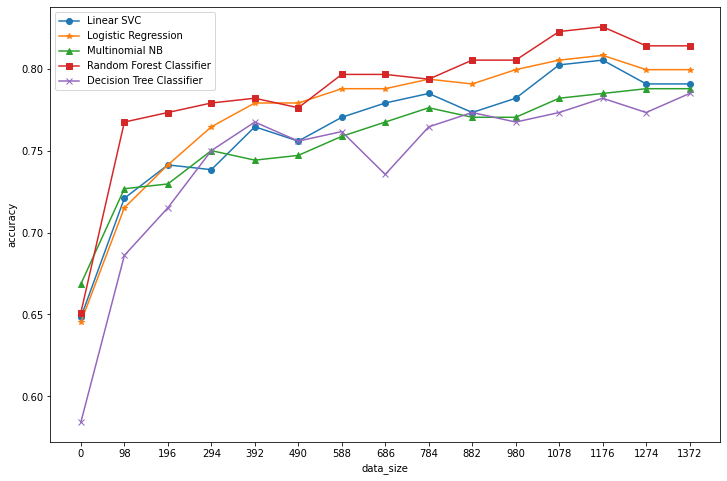

In [36]:
def plot_acc_curve(classifier, linestyle, label):    
    
    num_of_splits = 14
    each_split_size = len(X_train)//num_of_splits

    each_split = 98
    scores = []

    for i in range(num_of_splits+1):
        split_X_train = X_train[0:each_split]
        split_y_train = y_train[0:each_split]

        each_split += each_split_size

        classifier.fit(split_X_train, split_y_train)
        scores.append(classifier.score(X_test, y_test))
    
    m = 14
    n = 98
    x_splits = list(range(0, (m+1)*n, n))

    plt.xlabel('data_size')
    plt.ylabel('accuracy')
    plt.plot(x_splits, scores, linestyle, label = label)
    plt.xticks(x_splits)
    plt.legend(loc="best")
    
    return plt
    

plt.figure(figsize=(12,8))

# Linear SVC
classifier = SVC(kernel = 'linear', random_state = 0, C = 1, gamma = 0.1)
plot_acc_curve(classifier, linestyle = 'o-', label="Linear SVC")

# Logistic Regression
classifier = LogisticRegression(random_state = 0)
plot_acc_curve(classifier, linestyle = '*-', label="Logistic Regression")

# Multinomial NB
classifier = MultinomialNB()
plot_acc_curve(classifier, linestyle = '^-', label="Multinomial NB")

# Random Forest Classifier
classifier = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
plot_acc_curve(classifier, linestyle = 's-', label="Random Forest Classifier")

# Decision Tree Classifier
classifier = DecisionTreeClassifier()
plot_acc_curve(classifier, linestyle = 'x-', label="Decision Tree Classifier")

plt.show()

## PLotting the learning curves

In [29]:


# import numpy as np
# import matplotlib.pyplot as plt
# from sklearn.naive_bayes import GaussianNB
# from sklearn.svm import SVC
# from sklearn.datasets import load_digits
# from sklearn.model_selection import learning_curve
# from sklearn.model_selection import ShuffleSplit


# def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
#                         n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

#     if axes is None:
#         _, axes = plt.subplots(1, 3, figsize=(20, 5))

#     axes[0].set_title(title)
#     if ylim is not None:
#         axes[0].set_ylim(*ylim)
#     axes[0].set_xlabel("Training examples")
#     axes[0].set_ylabel("Score")

#     train_sizes, train_scores, test_scores, fit_times, _ = \
#         learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
#                        train_sizes=train_sizes,
#                        return_times=True)
#     train_scores_mean = np.mean(train_scores, axis=1)
#     train_scores_std = np.std(train_scores, axis=1)
#     test_scores_mean = np.mean(test_scores, axis=1)
#     test_scores_std = np.std(test_scores, axis=1)
#     fit_times_mean = np.mean(fit_times, axis=1)
#     fit_times_std = np.std(fit_times, axis=1)

#     # Plot learning curve
#     axes[0].grid()
#     axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
#                          train_scores_mean + train_scores_std, alpha=0.1,
#                          color="r")
#     axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1,
#                          color="g")
#     axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
#                  label="Training score")
#     axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
#                  label="Cross-validation score")
#     axes[0].legend(loc="best")

#     # Plot n_samples vs fit_times
#     axes[1].grid()
#     axes[1].plot(train_sizes, fit_times_mean, 'o-')
#     axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
#                          fit_times_mean + fit_times_std, alpha=0.1)
#     axes[1].set_xlabel("Training examples")
#     axes[1].set_ylabel("fit_times")
#     axes[1].set_title("Scalability of the model")

#     # Plot fit_time vs score
#     axes[2].grid()
#     axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
#     axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
#                          test_scores_mean + test_scores_std, alpha=0.1)
#     axes[2].set_xlabel("fit_times")
#     axes[2].set_ylabel("Score")
#     axes[2].set_title("Performance of the model")

#     return plt


# fig, axes = plt.subplots(3, 2, figsize=(10, 15))

# # X, y = load_digits(return_X_y=True)

# title = "Learning Curves (Naive Bayes)"
# # Cross validation with 100 iterations to get smoother mean test and train
# # score curves, each time with 20% data randomly selected as a validation set.
# cv = ShuffleSplit(n_splits=100, test_size=0.2, random_state=0)

# estimator = RandomForestClassifier(n_estimators = 100, criterion = 'entropy', random_state = 0)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 0], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# title = r"Learning Curves (SVM, linear, $\gamma=0.001$)"
# # SVC is more expensive so we do a lower number of CV iterations:
# cv = ShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
# estimator = LogisticRegression(random_state = 0)
# plot_learning_curve(estimator, title, X, y, axes=axes[:, 1], ylim=(0.7, 1.01),
#                     cv=cv, n_jobs=4)

# plt.show()

## Creating a json file and sending to the server

In [30]:
# cm_rf_p = cm_rf.astype('float') / cm_rf.sum(axis=1)[:, np.newaxis]
# cm_lr_p = cm_lr.astype('float') / cm_lr.sum(axis=1)[:, np.newaxis]
# cm_knn_p = cm_knn.astype('float') / cm_knn.sum(axis=1)[:, np.newaxis]
# cm_k_svc_p = cm_k_svc.astype('float') / cm_k_svc.sum(axis=1)[:, np.newaxis]
# cm_dt_p = cm_dt.astype('float') / cm_dt.sum(axis=1)[:, np.newaxis]

In [31]:
# unique, counts = np.unique(y_pred, return_counts=True)

In [32]:
# dict_pred_rf = dict(zip(unique, cm_rf_p.diagonal()))
# dict_pred_lr = dict(zip(unique, cm_lr_p.diagonal()))
# dict_pred_knn = dict(zip(unique, cm_knn_p.diagonal()))
# dict_pred_k_svc = dict(zip(unique, cm_k_svc_p.diagonal()))
# dict_pred_dt = dict(zip(unique, cm_dt_p.diagonal()))

In [33]:
# import json

# models = ['random_forest', 'linear_regression', 'knn', 'kernal_svc', 'decision_tree']
# pred_dict = [dict_pred_rf, dict_pred_lr, dict_pred_knn, dict_pred_k_svc, dict_pred_dt]

# predictions = {}
# for model, pred in zip(models, pred_dict):
#     predictions[model] = pred

# with open('prediction.json', 'w') as json_file:
#     json.dump(predictions, json_file)

In [34]:
# predictions

In [35]:
# To DO:
# Send json